In [1]:
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from torch.optim import RMSprop

import sys
import pandas as pd
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
import numpy as np
import base64
import cv2
import torch
import os
import torch.nn.functional as F
import math
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
import pickle
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import EvalCallback

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import StandardScaler

np.math = math
gym.register_envs(ale_py)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cuda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Establish Control Enviornment

In [3]:
def make_Cartpole_env():
  env = gym.make("CartPole-v1")
  return env

# A2C

In [4]:
from stable_baselines3 import A2C

In [5]:
n_envs = 8
Cartpole_env = DummyVecEnv([make_Cartpole_env for _ in range(n_envs)])  

In [6]:
Cartpole_env.observation_space.shape

(4,)

In [7]:
Cartpole_env.action_space.n

2

# Establish A2C

In [8]:
A2C_model = A2C(
    policy="MlpPolicy",
    env=Cartpole_env,
    ent_coef=0.0,
    vf_coef=0.25,
    verbose=1,
    tensorboard_log="./CartPole/a2c"
)

Using cpu device


# Train A2C

In [20]:
eval_callback = EvalCallback(
    Cartpole_env,
    best_model_save_path="./CartPole/a2c",
    log_path="./CartPole/a2c", 
    eval_freq=100000,  
    n_eval_episodes=10, 
    deterministic=True, 
    render=False,
)

n_timesteps = int(5e5)

A2C_model.learn(total_timesteps=n_timesteps, callback=eval_callback)

A2C_model.save("./CartPole/a2c")

Logging to ./CartPole/a2c\A2C_1
------------------------------------
| time/                 |          |
|    fps                | 1403     |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -0.532   |
|    explained_variance | 0.0191   |
|    learning_rate      | 0.0007   |
|    n_updates          | 594      |
|    policy_loss        | -0.476   |
|    value_loss         | 134      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1359     |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -0.565   |
|    explained_variance | 0.0124   |
|    learning_rate      | 0.0007   |
|    n_updates          | 694      |
|    policy_loss        | 0.714    |
|    v

# Load A2C Model

In [8]:
A2C_model = A2C.load("./CartPole/a2c/a2c.zip")

A2C_model.ent_coef = 0.0
A2C_model.vf_coef = 0.0

ModuleNotFoundError: No module named 'numpy._core.numeric'

In [10]:
A2C_model.policy 

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=2, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

# Collect Episode Data

In [11]:
n_envs = 1
Cartpole_env = DummyVecEnv([make_Cartpole_env for _ in range(n_envs)]) 

In [103]:
output_dir = "./CartPole/a2c/evaluation"
os.makedirs(output_dir, exist_ok=True)

num_episodes = 200

episode_records = []

def generate_column_names():
    return [
        "cart_position",
        "cart_velocity",
        "pole_angle",
        "pole_angular_velocity",
        "action",
        "reward"
    ]

for ep in range(1, num_episodes + 1):
    obs = Cartpole_env.reset()
    done = False

    episode_records.clear()

    while not done:
        # ---- CartPole features = raw observation ----
        features = obs[0]             # shape (4,)

        features = np.array(features)

        # ---- policy action ----
        action, _states = A2C_model.predict(obs, deterministic=True)

        # print(action)

        next_obs, reward, done, info = Cartpole_env.step(action)

        action_array = np.array([action]).flatten()
        reward_array = np.array([reward]).flatten()

        record = np.concatenate([
            features,
            action_array,
            reward_array
        ])

        episode_records.append(record)

        obs = next_obs

    # ---- save CSV ----
    file_path = os.path.join(output_dir, f"episode_{ep}.csv")

    df = pd.DataFrame(
        episode_records,
        columns=generate_column_names()
    )
    df.to_csv(file_path, index=False)

    episode_records.clear()

# Merge Episode

In [104]:
def merge_episode_data(dim_dir, output_file):
    """
    Merge all episode CSV files into a single CSV file.

    Args:
        dim_dir (str): directory containing episode_*.csv
        output_file (str): merged CSV output path
    """

    if os.path.exists(output_file):
        print(f"{output_file} already exists. Skipping merge.")
        return

    all_records = []

    for episode_file in sorted(os.listdir(dim_dir)):
        if episode_file.endswith(".csv"):
            episode_path = os.path.join(dim_dir, episode_file)
            df = pd.read_csv(episode_path)
            all_records.append(df)

    if len(all_records) == 0:
        print("No episode files found.")
        return

    merged_df = pd.concat(all_records, ignore_index=True)
    merged_df.to_csv(output_file, index=False)

    print(f"Merged data saved to {output_file}")

merge_episode_data(
    "./CartPole/a2c/evaluation",
    "./CartPole/a2c/eval_data.csv"
)

Merged data saved to ./CartPole/a2c/eval_data.csv


# Compute SHAP

In [15]:
# Step 1: Load and prepare the data
data = pd.read_csv('./CartPole/a2c/eval_data.csv')

X = data.drop(columns=['reward', 'action']).values
Y = data['reward'].values
Z = data['action'].values

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
X_tensor[0]

tensor([ 0.0435, -0.0344, -0.0068,  0.0009])

In [12]:
class ActionLogitFromFeatures(nn.Module):
    def __init__(self, mlp_extractor, action_net):
        super().__init__()
        self.policy_net = mlp_extractor.policy_net
        self.action_net = action_net

    def forward(self, state_features):
        x = self.policy_net(state_features)
        logits = self.action_net(x)               
        return logits     

In [13]:
A2C_MlpExtractor = A2C_model.policy.mlp_extractor
A2C_MlpExtractor

MlpExtractor(
  (policy_net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (value_net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
)

In [14]:
A2C_ActionNet = A2C_model.policy.action_net
A2C_ValueNet = A2C_model.policy.value_net

In [15]:
A2C_PolicyActor = ActionLogitFromFeatures(A2C_MlpExtractor, A2C_ActionNet)
A2C_PolicyActor(X_tensor[0])

tensor([ 9.0364, -9.0394], grad_fn=<ViewBackward0>)

In [ ]:
background_size = int(len(X_tensor) * 0.01)  # Choose 1% of the data
background_data = X_tensor[:background_size]

In [ ]:
explainer = shap.DeepExplainer(A2C_PolicyActor, background_data)
shap_values = explainer.shap_values(X_tensor, check_additivity=False)

In [ ]:
n_samples, n_features, n_actions = shap_values.shape
feature_names = data.drop(['reward','action'], axis=1).columns.tolist()

actions = Z.astype(int)           # shape = (n_samples,)
sample_idx = np.arange(n_samples) # [0,1,2,…,n_samples-1]

shap_max = shap_values[sample_idx, :, actions]

shap_df = pd.DataFrame(shap_max, columns=feature_names)
shap_df['action'] = Z

out_path = './CartPole/a2c/shap_data.csv'
shap_df.to_csv(out_path, index=False)
print(f"[+] Saved：{out_path}")

[+] Saved：./CartPole/a2c/shap_data.csv


In [12]:
shap_data = pd.read_csv('./CartPole/a2c/shap_data.csv').drop(columns=['action']).values
feature_names = pd.read_csv('./CartPole/a2c/shap_data.csv').drop(['action'], axis=1).columns.tolist()

In [13]:
shap_data[0]

array([5.10267353, 3.92817521, 0.33554733, 0.02625544])

In [16]:
X[0]

array([ 0.04345517, -0.03444139, -0.00684861,  0.00088888])

In [17]:
feature_names

['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']

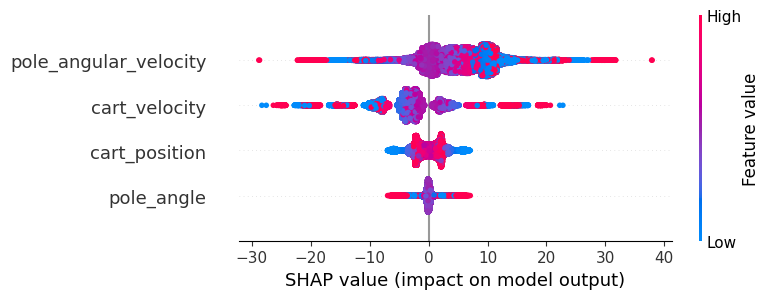

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(10,10))
shap.summary_plot(shap_data, X, feature_names=feature_names)
plt.savefig('./CartPole/a2c/CartPole_A2C_SHAP_value_chart.pdf', format='pdf', bbox_inches='tight')

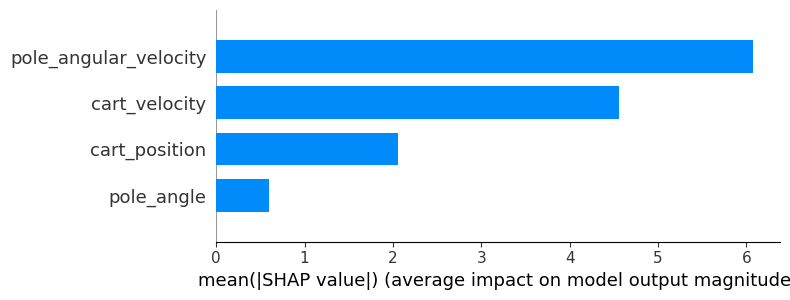

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(figsize=(10,10))
shap.summary_plot(shap_data, X, feature_names=feature_names, plot_type="bar")
plt.savefig('./CartPole/a2c/CartPole A2C SHAP value bar chart')

In [22]:
shapley_to_state_mapping = {}

for i in range(len(X_tensor)):
    state = X[i]  
    shapley_vector = shap_data[i]  
    
    shapley_to_state_mapping[tuple(shapley_vector)] = state

with open('./CartPole/a2c/shapley_to_state_mapping.pkl', 'wb') as f:
    pickle.dump(shapley_to_state_mapping, f)

print("The mapping between Shapley vectors and the original state space has been saved.")

The mapping between Shapley vectors and the original state space has been saved.


In [29]:
len(shap_data)

100000

In [24]:
print(shapley_to_state_mapping.get(tuple(shap_data[0])))

[ 0.04345517 -0.03444139 -0.00684861  0.00088888]


# Action K-Means Clustering

In [25]:
n_actions = Cartpole_env.action_space.n

kmeans = KMeans(n_clusters=n_actions) 
kmeans.fit(shap_data)

,n_clusters,np.int64(2)
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [26]:
labels = kmeans.labels_

centroids = kmeans.cluster_centers_

print(f"Cluster Labels: {labels}")
print(f"Cluster Centroids: {centroids}")

Cluster Labels: [0 0 0 ... 0 1 0]
Cluster Centroids: [[-0.18563615  0.07659564  0.15813865  0.77133291]
 [ 0.1275972  -5.97554681 -0.07785459  9.43507949]]


# Boundary Points Identification

In [79]:
def find_boundary_points(shap_values, n_clusters):

    boundary_points = []

    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            dist_to_centroids = cdist(shap_values, [centroids[i], centroids[j]], 'euclidean')
                
            dist_diff = np.abs(dist_to_centroids[:, 0] - dist_to_centroids[:, 1])
            boundary_index = np.argmin(dist_diff)
                
            boundary_point = shap_values[boundary_index]
            boundary_points.append((boundary_point, (i, j)))  

    return boundary_points

# Inverse Shapley Values

In [80]:
# find boundary points
boundary_points = find_boundary_points(shap_data, n_clusters=2)

print("boundary_points: ", boundary_points)

# find boundary data
boundary_data = []
# find shap inverse boundary data
shap_inverse_boundary_data = []
# iterate through boundary points
for boundary_point, clusters in boundary_points:

    # get two clusters
    i, j = clusters  

    print("current boundary point:", boundary_point)

    # get shap inverse boundary points
    shap_inverse_boundary_point = shapley_to_state_mapping.get(tuple(boundary_point))

    print("current shap inverse boundary point:", shap_inverse_boundary_point)

    # ---------------- RL-guided Labeling----------------

    action, _ = A2C_model.predict(shap_inverse_boundary_point, deterministic=True)

    print("Predicted action: ", action)

    boundary_data.append(list(boundary_point) + [i, j, action])

    shap_inverse_boundary_data.append(list(shap_inverse_boundary_point) + [i, j, action])

# get features
num_features = len(boundary_data[0]) - 3  

# define columns
columns = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity'] + ['Cluster_1', 'Cluster_2', 'Action_Label']

boundary_df = pd.DataFrame(boundary_data, columns=columns)
shap_inverse_boundary_df = pd.DataFrame(shap_inverse_boundary_data, columns=columns)

boundary_df.to_csv('./CartPole/a2c/boundary_points.csv', index=False)
shap_inverse_boundary_df.to_csv('./CartPole/a2c/shap_inverse_boundary_points.csv', index=False)

boundary_points:  [(array([-1.31518054, -2.83551168,  0.15362096,  5.23239088]), (0, 1))]
current boundary point: [-1.31518054 -2.83551168  0.15362096  5.23239088]
current shap inverse boundary point: [ 0.92455816  0.19585776 -0.0027412  -0.14853837]
Predicted action:  0


In [19]:
bd_data = pd.read_csv('./CartPole/a2c/eval_data.csv')

bd_X = bd_data.iloc[:, :-2].values  

bd_Y = bd_data['action'].values  

In [20]:
bd_X

array([[ 4.34551686e-02, -3.44413891e-02, -6.84861466e-03,
         8.88879527e-04],
       [ 4.27663401e-02, -2.29464456e-01, -6.83083711e-03,
         2.91403145e-01],
       [ 3.81770507e-02, -4.24488336e-01, -1.00277434e-03,
         5.81923902e-01],
       ...,
       [ 1.16011024e+00,  1.39808878e-01,  1.99259445e-03,
        -1.43125281e-01],
       [ 1.16290641e+00, -5.53415567e-02, -8.69911164e-04,
         1.50185600e-01],
       [ 1.16179955e+00,  1.39792845e-01,  2.13380088e-03,
        -1.42771631e-01]], shape=(100000, 4))

In [21]:
bd_Y

array([0., 0., 0., ..., 0., 1., 0.], shape=(100000,))

# Decision Boundary Regression using Linear Regression

### SILVER Framework

In [18]:
# linear regression model from SILVER paper
def SILVER_linear_regression(cart_position, cart_velocity, pole_angle, pole_angular_velocity):
    return -0.4875*cart_position - 0.9811*cart_velocity - 1.09*pole_angle - pole_angular_velocity

### Reshap Framework

In [22]:
Reshap_LinearRegression = LinearRegression()

Reshap_LinearRegression.fit(bd_X, bd_Y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [23]:
coefficient_names = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']

In [34]:
def round_and_clip(predictions, min_value=0, max_value=1):
    predictions_int = np.rint(predictions).astype(int)
    return np.clip(predictions_int, min_value, max_value)

In [25]:
def display_linear_formula(lr, feature_names, F_name='f1', tol=1e-16):

    coefs = lr.coef_.ravel()
    intercept = float(lr.intercept_)
    
    terms = []
    for w, name in zip(coefs, feature_names):

        if abs(w) < tol:
            continue
        sign = "+" if w > 0 else "−"
        terms.append(f"{sign} {abs(w):.2e}·{name}")
    
    if not terms:
        formula = f"{F_name}(x) = {intercept:.2e}"
    else:
        formula = f"{F_name}(x) = {intercept:.2e} " + " ".join(terms)
    
    return formula

In [26]:
display_linear_formula(Reshap_LinearRegression, coefficient_names, F_name="f")

'f(x) = -4.98e-01 + 8.43e-01·cart_position + 3.58e+00·cart_velocity + 6.70e+00·pole_angle + 4.48e+00·pole_angular_velocity'

# Performance Evaluation

In [27]:
def RL_run_episode(env, num_episodes, model):

    rewards = []

    for ep in range(num_episodes):
        obs = env.reset() 
        done = False
        total = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True) 

            next_obs, reward, done, info = env.step(action)

            total += reward
            obs = next_obs       

        rewards.append(total)

    return rewards

def SILVER_run_episode(env, num_episodes, model):

    rewards = []

    for ep in range(num_episodes):
        obs = env.reset() 
        done = False
        total = 0

        while not done:

            cart_position = obs[0][0]
            cart_velocity = obs[0][1]
            pole_angle = obs[0][2]
            pole_angular_velocity = obs[0][3]
            
            # compute result of linear regression
            f = model(cart_position, cart_velocity, pole_angle, pole_angular_velocity)
            
            # select action
            action = [0] if f > 0 else [1]

            next_obs, reward, done, info = env.step(action)

            total += reward
            obs = next_obs
        rewards.append(total)        

    return rewards

def ReShap_run_episode(env, num_episodes, model):

    rewards = []

    for ep in range(num_episodes):
        obs = env.reset() 
        done = False
        total = 0

        while not done:
            
            action = model.predict(obs) 

            if isinstance(model, LinearRegression):
                action = round_and_clip(action)

            next_obs, reward, done, info = env.step(action)

            total += reward
            obs = next_obs
        rewards.append(total)        

    return rewards

### A2C

In [28]:
A2C_result = RL_run_episode(Cartpole_env, 100, A2C_model) 

print(A2C_result)
print(sum(A2C_result))

[array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([50

In [35]:
A2C_result_np = np.array(A2C_result)
np.save("./CartPole/A2C_result_np.npy", A2C_result_np)

### SILVER

In [30]:
SILVER_result = SILVER_run_episode(Cartpole_env, 100, SILVER_linear_regression) 

print(SILVER_result)
print(sum(SILVER_result))

[array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([50

In [36]:
SILVER_result_np = np.array(SILVER_result)
np.save("./CartPole/A2C_SILVER_result_np.npy", SILVER_result_np)

### ReShap

In [32]:
ReShap_result = ReShap_run_episode(Cartpole_env, 100, Reshap_LinearRegression) 

print(ReShap_result)
print(sum(ReShap_result))

[array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([50

In [37]:
ReShap_result_np = np.array(ReShap_result)
np.save("./CartPole/A2C_ReShap_result_np.npy", ReShap_result_np)